# Multi-Layer Perceptron for MNIST Dataset

## Perceptron 

A perceptron is a single neuron model that is a precursor to larger neural networks. It is a simple binary classifer (linear) to separate data between two features.

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_binary.png")

## Multi-Layer Perceptron

The goal is to develop robust algorithms and data structures that we can use to model difficult problems.

The power of neural networks come from their ability to **learn the representation** in your training data and how to best relate it to the output variable that you want to predict. In this sense neural networks learn a mapping.

The predictive capability of neural networks comes from the multi-layered structure of the networks. The data structure can pick out (learn to represent) features at different scales or resolutions and combine them into higher-order features. For example from lines, to collections of lines to shapes.

For more information on MLP visit https://machinelearningmastery.com/neural-networks-crash-course/

### Hidden layers

Hidden layers are called "hidden" because their values are not given in the input data. Instead, the previous layer of the model provides a new representation of the input.

In [4]:
Image(url= "https://www.safaribooksonline.com/library/view/getting-started-with/9781786468574/graphics/B05474_04_05.jpg")

Example of different representations between hidden layers:

In [5]:
Image(url= "http://playground.tensorflow.org/preview.png")

## Problem 

MINST is a database consisting of handwritten digits between 0-9. Each image is a 28 x 28 pixel grayscale for a total of 784 features.

A multi-layer perceptron model is trained and tested on 70,000 images.

In [41]:
Image(url= "https://guillaumebrg.files.wordpress.com/2016/01/mnist_and_mlp1.png?w=507&h=222")

## Generate a Backend 

Neon features highly optimized CPU (MKL) and GPU computational backends for fast matrix operations. 

In [20]:
from neon.backends import gen_backend

# batch_size = (num of training examples per epoch)
gen_backend(backend='cpu', batch_size=128)

The neon backend is easily swappable, meaning that the same code will run for both the GPU and CPU backends.

## MNIST Data Preparation

The MNIST dataset can be found on Yann LeCunn’s website. Neon provides an easy function that downloads the MNIST dataset into your nervana/data/ directory and loads it into memory.

In [6]:
from neon.data import MNIST

mnist = MNIST()

(X_train, y_train), (X_test, y_test), nclass = mnist.load_data()

This function automatically splits the images X and labels y into training (60,000 examples) and testing (10,000 examples) data. The training images X_train is a numpy array with shape (num_examples, num_features) = (60000, 784)

Nclass is set to 10 to represent the 10 classes that need to be classified (digits: 0-9)

To view a sample image in the training dataset, reshape the numpy array (28, 28) and load the image using matplotlib.

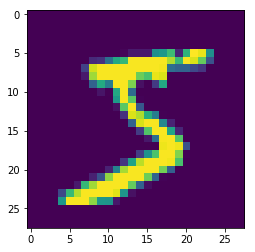

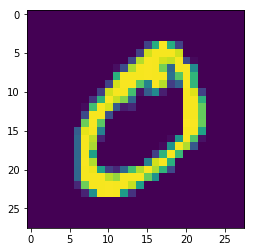

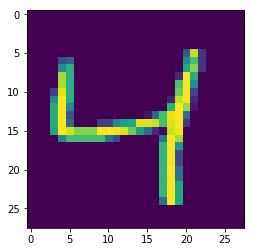

In [7]:
import matplotlib.pyplot as plt

for i in range(3): # Show first three images in train data
    sample_image = X_train[i].reshape(28,28)

    plt.imshow(sample_image)

    plt.show()

During training, neon iterates over the training examples to compute the gradients. We use the following commands to set up the ArrayIterator object that we send to the optimizer.

In [8]:
from neon.data import ArrayIterator

#  (num_examples, num_features) = (60000, 784).
train_set = ArrayIterator(X_train, y_train, nclass=nclass)
#  (num_examples, num_features) = (10000, 784).
test_set = ArrayIterator(X_test, y_test, nclass=nclass)

Since MNIST is a small dataset, the set up for the ArrayIterator object is relatively easy. However, for large datasets that cannot fit into memory (e.g. ImageNet or Sports-1M), the data has to be efficiently loaded and fed to the optimizer in batches. This requires more advanced iterators described in Loading Data.

## Model specification

Hyperparameters required to the deep learning model:
- a list of layers
- a cost function
- a learning rule

### Model architecture: Layers 

#### Initializing weights 

Neon contains an array of intializers. For the MLP MNIST tutorial we intialize the weights using a Gaussian distribution with zero mean and 0.01 standard deviation.

In [9]:
from neon.initializers import Gaussian

def initialize_weights():
    """
    This is a function to Initialize the weights using a Normal Gaussian Distribution 
    """
    init_norm = Gaussian(loc=0.0, scale=0.01)
    return init_norm

#### Affine layer object 

Neon creates linear layers using Affine function. The parameters required are:
- nout: desired size or shape of layer output
- init: initializer object to use for initializing layer weights
- activation: defines the output of the node

In [10]:
from neon.layers import Affine

def createAffine(n_hidden,activation_func,weight_init):
    """
    This method creates a AFFINE (Fully Connected Hidden Layer). 
    This is a normal linear layer used in Neural Networks.
    
    Params:
    @ n_hidden        : No of hidden units to use in the layer
    @ weight_init     : The weight Initializer to be used to initialize weights in this layer
    @ activation_func : The activation function to be used in the layer
    
    Returns:
    Affine Layer Object
    """
    return Affine(nout=n_hidden, init=weight_init, activation=activation_func)

#### Create hidden layers 

In [11]:
from neon.transforms import Rectlin, Softmax

def create_hidden_layers(layers,
                         no_of_layers,
                         hidden_unit_list,
                         activ_func_list,
                         weight_init_list):
    """
    This method creates the complete hidden layer architecture.
    
    Params:
    @ layers           : This is a list containing any previous layers or no layers 
    @ no_of_layers     : The no of hidden layers to create
    @ hidden_unit_list : A list of no of hidden units to use in each layer
    @ activ_func_list  : A list of Activation functions to be used in each layer
    @ weight_init_list : A list of weight initializers to be used in each layer
    
    Returns:
    A list of the newly created hidden layers
    """
    for index,num in enumerate(hidden_unit_list):
        layers.append(createAffine(n_hidden=num,
                                   weight_init=weight_init_list[index],
                                   activation_func=activ_func_list[index]))
    return layers

The model is specified as a list of layers. For classifying MNIST images, we use a multi-layer perceptron with fully connected layers.

In [12]:
layers = []
no_of_layers = 3
hidden_unit_list = [30,50,10]
activ_func_list = [Rectlin(),Rectlin(),Softmax()]
weight_init_list = [initialize_weights() for i in range(len(hidden_unit_list))]
layers = create_hidden_layers(layers,
                              no_of_layers,
                              hidden_unit_list,
                              activ_func_list,
                              weight_init_list)

Three Affine layers are created:
- 1st hidden layer with 30 hidden units and a rectified linear activation function, Rectlin()
- 2nd hidden layer with 50 hidden units and a rectified linear activation function, Rectlin()
- Output layer with 10 units to match the number of labels (classes) in the MNIST dataset. Activation function Softmax() is used to ensure the outputs sum to one and are within the range [0,1]

### Initalize model object 

Construct the model

In [13]:
from neon.models import Model

mlp = Model(layers=layers)

### Cost 

The cost function is wrapped within a GeneralizedCost layer, which handles the comparison of the outputs with the provided labels in the dataset. One common cost function which we use here is the cross entropy loss.

In [14]:
from neon.layers import GeneralizedCost
from neon.transforms import CrossEntropyMulti

cost = GeneralizedCost(costfunc=CrossEntropyMulti())

Benefits of cost function:
- make our networks better at generalizing beyond the training data
- better method for intializing the weights in the network
- set of heuristics to help choose good hyper-parameters

### Learning rules 

For learning, we use stochastic gradient descent with a learning rate of 0.1 and momentum coefficient of 0.9.

In [16]:
from neon.optimizers import GradientDescentMomentum

optimizer = GradientDescentMomentum(0.1, momentum_coef=0.9)

### Callbacks 

Neon provides an API for calling operations during the model fit. Here we set up the default callback, which is displaying a progress bar for each epoch.

In [19]:
from neon.callbacks.callbacks import Callbacks
from neon.callbacks.callbacks import ProgressBarCallback

callbacks = Callbacks(mlp, eval_set=test_set)
callbacks.add_callback(ProgressBarCallback())

## Fit the model 

At the beginning of the fitting procedure, neon propagates train_set through the model to set the input and output shapes of each layer. Each layer has a configure() method that determines the appropriate layer shapes, and an allocate() method to set up the needed buffers for holding the forward propagation information.

During the training, neon sends batches of the training data through the model, calling each layers’ fprop() and bprop() methods to compute the gradients and update the weights.

In [25]:
mlp.fit(dataset=train_set,
        optimizer=optimizer,
        num_epochs=10, # epoch = (num of passes of all the training examples)
        cost=cost,
        callbacks=callbacks)

Epoch 0   [Train |████████████████████|  469/469  batches, 0.24 cost, 3.39s]

Epoch 1   [Train |████████████████████|  469/469  batches, 0.15 cost, 3.71s]

Epoch 2   [Train |████████████████████|  469/469  batches, 0.12 cost, 3.91s]

Epoch 3   [Train |████████████████████|  468/468  batches, 0.11 cost, 3.83s]

Epoch 4   [Train |████████████████████|  468/468  batches, 0.12 cost, 3.94s]

Epoch 5   [Train |████████████████████|  468/468  batches, 0.11 cost, 3.97s]

Epoch 6   [Train |████████████████████|  468/468  batches, 0.12 cost, 3.98s]

Epoch 7   [Train |████████████████████|  468/468  batches, 0.09 cost, 4.16s]

Epoch 8   [Train |████████████████████|  468/468  batches, 0.09 cost, 3.94s]

Epoch 9   [Train |████████████████████|  468/468  batches, 0.09 cost, 3.90s]



## Using the trained model 

The model is now trained, we can used the trained model to classify an image, measure performance, and visualize the weights and training results.

### Inference 

Given the images from the test_set, fetch the output of the final model layer.

In [28]:
# (num_test_examples, num_outputs) = (10000,10)
results = mlp.get_outputs(test_set)

### Performance 

Neon supports functions for evaluating performance using custom metrics. Here we measure the misclassification rate on the held out test set.

In [27]:
from neon.transforms import Misclassification

# evaluate the model on test_set using the misclassification metric
error = mlp.eval(test_set, metric=Misclassification())*100
print('Misclassification error = %.1f%%' % error)

Misclassification error = 5.5%


### View misclassified images 

Model misclassified image as: 7
Correct image label is: 9


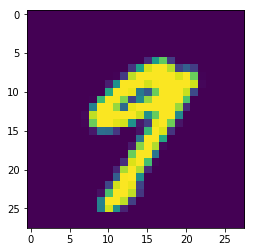

In [92]:
import numpy as np

misclassified_img = []
for row in range(results.shape[0]):
    a = results[row]
    i = np.unravel_index(a.argmax(), a.shape)

    if (i[0] == y_test[row]) == False:
        misclassified_img.append(row)

a = results[misclassified_img[0]]
i = np.unravel_index(a.argmax(), a.shape)

print('Model misclassified image as:', i[0])
print('Correct image label is:', y_test[misclassified_img[0]])

plt.imshow(X_test[misclassified_img[0]].reshape(28,28))

plt.show()